# day 285,day 291,day 293

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch,torchvision
import requests,os,zipfile
from pathlib import Path
from PIL import Image
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import time
from io import BytesIO

# ex: 1 Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels. Check out 03. PyTorch Computer Vision section 10 for idea.

## goals:
* download the data
* get train and test data from the zipfile
* get train_dataloader and test_dataloader
* transform them to something that the efficient_net_b3 model was trained on.
* import efficient_net_b3 model
* freeze some of its layers.
* modify the classifier layer of the model to the length of the class_names of your model.
* define the loss and optimizer parameter
* train the model with the custom data using training engine from going_modular.
* predict on the x_test
* create a confusion matrix.
* plot the confusion matrix.





In [2]:
# downloading the data
!git clone https://github.com/mrdbourke/pytorch-deep-learning
!mv pytorch-deep-learning/going_modular . # remember to put this dot(.) at the end
!mv pytorch-deep-learning/data . # remember to put this dot(.) at the end.
!rm -rf pytorch-deep-learning

Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Counting objects: 100% (1244/1244), done.
remote: Compressing objects: 100% (241/241), done.
remote: Total 4056 (delta 1079), reused 1090 (delta 1000), pack-reused 2812
Receiving objects: 100% (4056/4056), 651.13 MiB | 21.43 MiB/s, done.
Resolving deltas: 100% (2372/2372), done.
Updating files: 100% (248/248), done.


In [3]:
# open the zipfile

data_path = Path('data')
image_path = data_path / 'images'

image_path.mkdir(parents=True,exist_ok=True)

with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip','r') as zip:
  zip.extractall(image_path)
  zip.close()

In [4]:
# get train_dataloader and test_dataloder
from going_modular.going_modular import data_setup
train_dir = 'data/images/train'
test_dir = 'data/images/test'
batch_size = 32
transforms = torchvision.models.EfficientNet_B3_Weights.DEFAULT.transforms()

train_dataloader,test_dataloader,class_names =  data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    batch_size = batch_size,
    transform = transforms
)

In [2]:
# force-reinstall torchvision
!pip install --force-reinstall torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 67.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 76.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 69.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.2/133.2 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.0/169.0 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 74.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
# import efficient_net_b3
weights = torchvision.models.EfficientNet_B3_Weights.DEFAULT
model = torchvision.models.efficientnet_b3(weights = weights)


# freeze the layers
for parameter in model.features.parameters():
  parameter.requires_grad = False

# modify the classifier layer of the model to the length of the output classes of our data.
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2,inplace=True),
    torch.nn.Linear(in_features=1536,
                    out_features=len(class_names)#data specific)
                    )
)

# define the loss and optimizer functions
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters())


# train the model with our custom data
from going_modular.going_modular import engine
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def total_time(start,end):
  total = end-start
  print("Total Runnin TIME is: {:.3f}".format(total))

start = time.perf_counter()
history = engine.train(model,
                       train_dataloader,
                       test_dataloader,
                       optimizer,
                       loss,
                       epochs=10,
                       device=device)
end = time.perf_counter()
total_time(start,end)



Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:03<00:00, 13.2MB/s]


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0775 | train_acc: 0.4453 | test_loss: 1.0125 | test_acc: 0.6402
Epoch: 2 | train_loss: 0.9107 | train_acc: 0.6797 | test_loss: 0.9136 | test_acc: 0.6723
Epoch: 3 | train_loss: 0.7987 | train_acc: 0.7266 | test_loss: 0.7914 | test_acc: 0.7434
Epoch: 4 | train_loss: 0.6840 | train_acc: 0.9375 | test_loss: 0.6985 | test_acc: 0.8561
Epoch: 5 | train_loss: 0.6777 | train_acc: 0.8047 | test_loss: 0.6609 | test_acc: 0.8248
Epoch: 6 | train_loss: 0.5803 | train_acc: 0.9102 | test_loss: 0.5465 | test_acc: 0.9479
Epoch: 7 | train_loss: 0.5571 | train_acc: 0.8906 | test_loss: 0.5156 | test_acc: 0.9072
Epoch: 8 | train_loss: 0.6056 | train_acc: 0.7500 | test_loss: 0.4980 | test_acc: 0.9176
Epoch: 9 | train_loss: 0.5310 | train_acc: 0.8047 | test_loss: 0.5393 | test_acc: 0.8674
Epoch: 10 | train_loss: 0.5184 | train_acc: 0.8203 | test_loss: 0.5026 | test_acc: 0.8674
Total Runnin TIME is: 38.491


In [6]:
# predict on entire test_data
predictions = []
pred_probs = []
actuals = []
pred_label = []
actual_label = []
model.eval()
with torch.inference_mode():
  for x_test,y_test in test_dataloader:
    x_test,y_test = x_test.to(device),y_test.to(device)
    test_logits = model(x_test)
    test_predictions = test_logits.argmax(dim=1)
    test_pred_probs = torch.softmax(test_logits,dim=1).max(dim=1)

    for index, value in enumerate(test_predictions):
      test_pred_label = class_names[value]
      test_actual_label = class_names[y_test[index]]
      pred_label.append(test_pred_label)
      actual_label.append(test_actual_label)

    """ put the thing to cpu because sklearn
    doesn't work with GPU"""
    predictions.append(test_predictions.cpu())
    actuals.append(y_test.cpu())
    pred_probs.append(test_pred_probs.values.cpu())

# concatenating all the predictions
predictions = torch.cat(predictions)
actuals = torch.cat(actuals)
pred_probs = torch.cat(pred_probs)



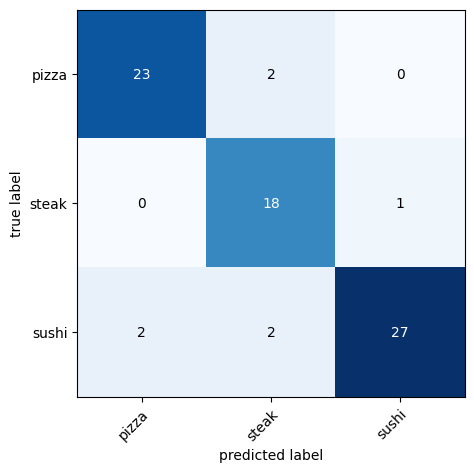

In [7]:
# making the confusion matrix
cm = confusion_matrix(actuals,predictions)

plot_confusion_matrix(cm,
                      figsize=(5,10),
                      class_names = class_names);

# exploration,analysis and freethrows

In [ ]:
class_names

['pizza', 'steak', 'sushi']

In [ ]:
pred_label[35:45]

['steak',
 'steak',
 'steak',
 'steak',
 'steak',
 'steak',
 'steak',
 'steak',
 'steak',
 'sushi']

In [ ]:
actual_label[35:45]

['steak',
 'steak',
 'steak',
 'steak',
 'steak',
 'steak',
 'steak',
 'steak',
 'steak',
 'sushi']

In [ ]:
pred_probs

[tensor([0.4889, 0.7451, 0.7505, 0.6982, 0.4839, 0.6254, 0.6962, 0.8118, 0.6917,
         0.8178, 0.6663, 0.7214, 0.3784, 0.4850, 0.4126, 0.5164, 0.5317, 0.6130,
         0.7031, 0.7462, 0.6451, 0.6778, 0.7345, 0.6126, 0.4162, 0.6362, 0.4587,
         0.3969, 0.6673, 0.5353, 0.6920, 0.6081], device='cuda:0'),
 tensor([0.6913, 0.5579, 0.4276, 0.5652, 0.6326, 0.5839, 0.3991, 0.5989, 0.5373,
         0.4634, 0.4777, 0.4928, 0.5027, 0.3744, 0.5445, 0.4249, 0.5629, 0.6217,
         0.5784, 0.4342, 0.5378, 0.4956, 0.7270, 0.4956, 0.4309, 0.5279, 0.3953,
         0.6156, 0.6365, 0.5339, 0.5495, 0.5883], device='cuda:0'),
 tensor([0.4952, 0.3787, 0.4170, 0.5830, 0.7495, 0.4610, 0.3981, 0.5546, 0.5244,
         0.6152, 0.7651], device='cuda:0')]

In [ ]:
predictions

[tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 1, 1, 1, 1, 2, 1, 1]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2,
         0, 2, 2, 2, 2, 2, 2, 2]),
 tensor([2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 2])]

In [ ]:
len(predictions)

75

In [ ]:
actuals

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2])

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary

summary(model,
        input_size=[1,3,300,300],
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 300, 300]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 300, 300]     [1, 1536, 10, 10]    --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 300, 300]     [1, 40, 150, 150]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 300, 300]     [1, 40, 150, 150]    (1,080)              False
│    │    └─BatchNorm2d (1)                                  [1, 40, 150, 150]    [1, 40, 150, 150]    (80)                 False
│    │    └─SiLU (2)                                         [1, 40, 150, 150]    [1, 40, 150, 150]    --                   --
│    └─Sequential (1)                                        [1, 40, 150, 150]    [1, 2

# ex2: Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:

* Predicting across all of the test dataset, storing the labels and predicted probabilities.
* Sort the predictions by wrong prediction and then descending predicted probabilities, this will give you the wrong predictions with the highest prediction probabilities, in other words, the "most wrong".
* Plot the top 5 "most wrong" images, why do you think the model got these wrong?


## goals:

1. create a df containing pred_probs, pred_label, and actual_label..
2. filter the df in descending order by pred_probs where actual_label != pred_label.
3. convert the dataloader into dataset
4. acess the indices of the wrong images, put it inside the test_data and get the image to show.


In [8]:
df = pd.DataFrame({'pred_label':pred_label,'actual_label':actual_label,
                   'pred_probs':pred_probs})
df.head(10)

,pred_label,actual_label,pred_probs
0,pizza,pizza,0.569071
1,pizza,pizza,0.856390
2,pizza,pizza,0.821490
3,pizza,pizza,0.699701
4,pizza,pizza,0.533123
5,pizza,pizza,0.757214
6,pizza,pizza,0.619775
7,pizza,pizza,0.775439
8,pizza,pizza,0.788477
9,pizza,pizza,0.898897


In [9]:
boolean = df['pred_label'] != df['actual_label']

top_6_wrong = df[boolean].sort_values(by='pred_probs',ascending=False)[:6]
top_6_wrong

,pred_label,actual_label,pred_probs
29,sushi,steak,0.620740
12,steak,pizza,0.599711
70,steak,sushi,0.455819
65,steak,sushi,0.420759
47,pizza,sushi,0.391532
24,steak,pizza,0.357299


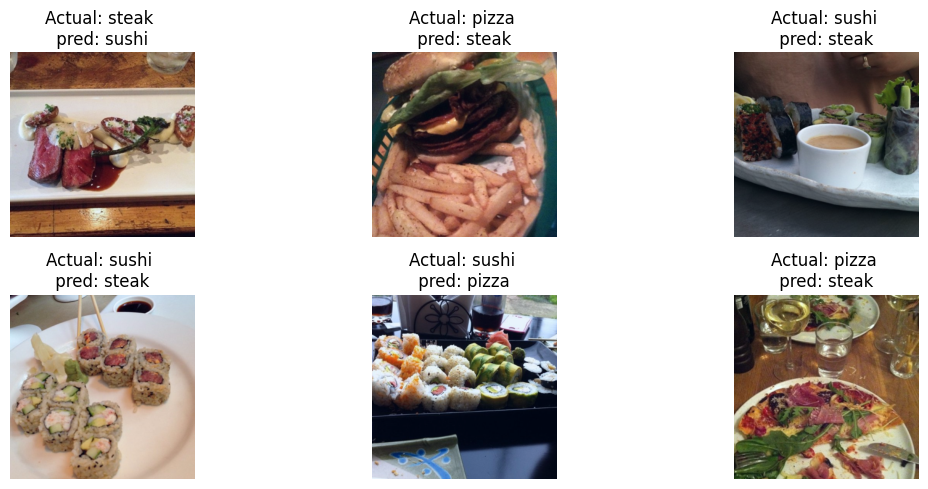

In [10]:
# convert the dataloader into dataset
test_data = test_dataloader.dataset

wrong_indices = top_6_wrong.index
wrong_pred_labels = top_6_wrong['pred_label'].values
wrong_actual_labels = top_6_wrong['actual_label'].values

# visualizing the images
plt.figure(figsize=(12,5))
for i,index in enumerate(wrong_indices):
  image,label = test_data[index]

  # min max scaling the image to make it have values between 0 and 1
  min = torch.min(image)
  max = torch.max(image)

  if min != max:
    scaled_image = (image - min)/(max-min)
  else:
    scaled_image = image/max

  plt.subplot(2,3,i+1)
  plt.imshow(scaled_image.permute(1,2,0))
  plt.title('Actual: {} \n pred: {} '.format(wrong_actual_labels[i],

                                             wrong_pred_labels[i]))
  plt.axis('off')

plt.tight_layout()
plt.show()

# conclusion:

* we could have improved the quality of these training images to get the model predict with more accuracy.
* the model must be able to target a specific part of the image and classify it as what it is rather than reading the whole thing under a single label for example, lets say we want to train our model to predict pizza but not only pizza is there in the image but the room, lights in the room, table on which the pizza was placed, spoon, table cloth, limbs of chair that are partly visible in the picture and perhaps some human's hand, fingers, you get idea.. when you train the model with this picture under the label 'pizza' not only the patterns of the pizza does the model understand but the whole environment of the pizza and all the things around the pizza are wrongly labelled as pizza.
* To avoid this we have to make the model trained with different things under different labels. how are we, natural organisms, able to classify different things correctly even with limited data? it is because of multiple-data exposure, when we see a picture with pizza in it not only can we able to identify the pizza in it but other things in it as well. this is what i believe imagenet is trying to achieve, to give the models a sense of what everything is, but not only do we have visual sense of things, but we have touched, smelled and even sometimes licked them (multiple-data exposure with multiple-sensories). I think we can achieve that only through robots.

# exploration,analysis and freethrows

In [ ]:
test_data = test_dataloader.dataset

In [ ]:
image,label = test_data[29]

In [ ]:
image

tensor([[[-1.5014, -1.6555, -1.4843,  ...,  0.3823,  0.3823,  0.3652],
         [-1.6384, -1.6384, -1.5014,  ...,  0.3481,  0.3652,  0.3652],
         [-1.6727, -1.6042, -1.5357,  ...,  0.3652,  0.3652,  0.3481],
         ...,
         [-0.8678, -0.8678, -0.8335,  ..., -1.0904, -1.0904, -1.1418],
         [-0.7650, -0.7822, -0.7479,  ..., -1.1247, -1.0904, -1.0904],
         [-0.7137, -0.7993, -0.7479,  ..., -1.1760, -1.1247, -1.0733]],

        [[-1.6681, -1.7731, -1.6155,  ..., -0.0924, -0.0924, -0.1099],
         [-1.7731, -1.7556, -1.6155,  ..., -0.1275, -0.1275, -0.1275],
         [-1.8081, -1.7206, -1.6506,  ..., -0.1275, -0.1275, -0.1450],
         ...,
         [-0.7402, -0.7402, -0.7052,  ..., -0.9328, -0.9328, -0.9853],
         [-0.6352, -0.6527, -0.6176,  ..., -0.9678, -0.9328, -0.9328],
         [-0.5826, -0.6702, -0.6176,  ..., -1.0203, -0.9678, -0.9153]],

        [[-1.6650, -1.7870, -1.6476,  ..., -0.5321, -0.5321, -0.5495],
         [-1.7696, -1.7696, -1.6476,  ..., -0

In [ ]:
class_names[label]

'steak'

In [ ]:
top_6_wrong['pred_label'][29]

'steak'

In [ ]:
top_6_wrong['pred_label'].values

array(['sushi', 'pizza', 'pizza', 'pizza', 'pizza', 'steak', 'steak'],
      dtype=object)

In [ ]:
top_6_wrong['pred_label'].index

Int64Index([29, 51, 56, 47, 66, 70, 12], dtype='int64')

In [ ]:
top_6_wrong.index

Int64Index([29, 51, 56, 47, 66, 70, 12], dtype='int64')

In [ ]:
len(wrong_indices)

6

# 3. Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?

In [11]:

def predict_custom_image(image_url):
  from io import BytesIO
  img = Image.open(BytesIO(requests.get(image_url).content))

  transform = torchvision.models.EfficientNet_B3_Weights.DEFAULT.transforms()
  image_t = transform(img)

  # adding a batch dimension for the model to train on
  image_t = torch.unsqueeze(image_t,dim=0)

  # putting it on same device
  image_t = image_t.to(device)

  # make predictions with the image
  model.eval()
  with torch.inference_mode():
    logits = model(image_t)
    prediction = logits.argmax(dim=1)
    pred_prob = torch.max(torch.softmax(logits,dim=1),dim=1)
    pred_label = class_names[prediction]


  # show the image with pred title
  plt.imshow(img)
  plt.title("predicted label: '{}' \n probability: {:.3f}".format(pred_label,
                                                              pred_prob[0].cpu().numpy()[0]))
  plt.axis('off')
  plt.show()



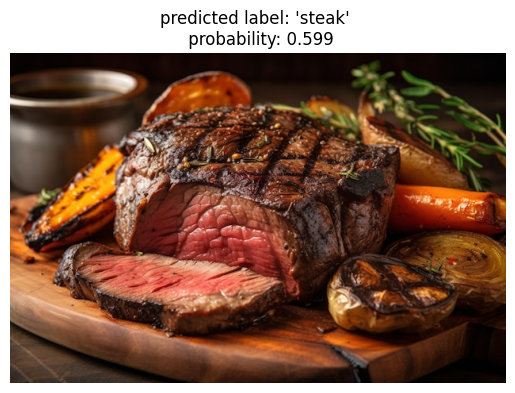

In [12]:
image_url = 'https://img.freepik.com/free-photo/juicy-steak-medium-rare-beef-with-spices-grilled-vegetables_24972-2328.jpg'

predict_custom_image(image_url)

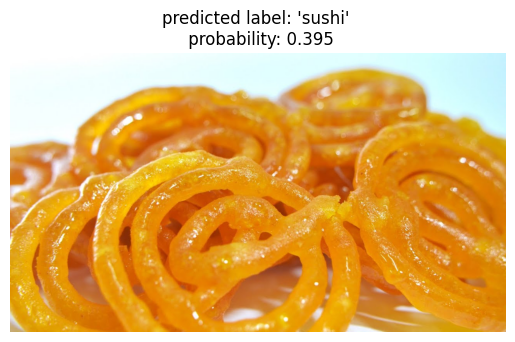

In [13]:
# predicting on image that isn't pizza, steak or sushi

image_url = 'https://i.ytimg.com/vi/5CK7JbvM-8c/maxresdefault.jpg'
predict_custom_image(image_url)

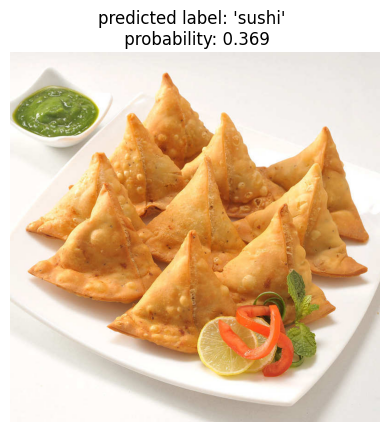

In [14]:
# predicting on an image that is not pizza, sushi or steak
image_url = 'https://static.toiimg.com/thumb/53723352.cms?imgsize=212203&width=800&height=800'
predict_custom_image(image_url)

# conclusion:

* this model we have created is inadequate for the real world.
* its universe comprise only of pizza, steak and sushi(its training data) and nothing else.
* I think we need to make this classifier layer more dynammic in such a way that the model would rummage through all its network to pick one of the most relevant classes among all the data it got exposed to.
* The act of living is in dynamism, fluidity, and flow. Anything static will only seem life-less. unchanging things are lifeless.
* With that note we can conclude that the data the models gets trained with need to be dynamic(updated in time), the memory of the model need to be dynamic(keeping only the relevant information on top and discarding the unused ones like all natural systems), therfore the action of the model will also be dynammic.

# 5. Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.
* You can find the 20% Pizza, Steak, Sushi dataset on the course GitHub. It was created with the notebook extras/04_custom_data_creation.ipynb.

In [15]:
# unzipping the files;

data_path = Path('data')
image_path20 = data_path / 'images20_percent'

image_path20.mkdir(parents=True,exist_ok=True)

with zipfile.ZipFile(data_path / 'pizza_steak_sushi_20_percent.zip') as zip:
  zip.extractall(image_path20)
  zip.close()

In [16]:
# creating the new dataloaders;
from going_modular.going_modular import data_setup
import os

train_dir = 'data/images20_percent/train'
test_dir = 'data/images20_percent/test'
transform = torchvision.models.EfficientNet_B3_Weights.DEFAULT.transforms()
train_dataloader,test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=transform,
    batch_size=32,
    num_workers=os.cpu_count()
)


In [17]:
# create the model and train the data
weights = torchvision.models.EfficientNet_B3_Weights.DEFAULT
model2 = torchvision.models.efficientnet_b3(weights=weights)

# freeze the layers by setting their gradients to False
for parameter in model2.features.parameters():
  parameter.requires_grad = False

# train only the classifier layer with custom data
model2.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2,inplace=True),
    torch.nn.Linear(in_features=1536,
                    out_features=len(class_names))
)

# compile the model
loss = torch.nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(params=model2.parameters())

# fit the model
from going_modular.going_modular import engine
start = time.perf_counter()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
history2 = engine.train(model2,
                        train_dataloader,
                        test_dataloader,
                        optimizer,
                        loss,
                        epochs=10,
                        device=device)
end = time.perf_counter()
total_time(start=start,end=end)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9647 | train_acc: 0.5646 | test_loss: 0.7984 | test_acc: 0.9472
Epoch: 2 | train_loss: 0.6973 | train_acc: 0.8812 | test_loss: 0.5935 | test_acc: 0.9631
Epoch: 3 | train_loss: 0.6131 | train_acc: 0.8688 | test_loss: 0.4795 | test_acc: 0.9597
Epoch: 4 | train_loss: 0.5070 | train_acc: 0.8562 | test_loss: 0.4433 | test_acc: 0.9659
Epoch: 5 | train_loss: 0.4177 | train_acc: 0.9146 | test_loss: 0.3631 | test_acc: 0.9472
Epoch: 6 | train_loss: 0.4033 | train_acc: 0.9354 | test_loss: 0.3456 | test_acc: 0.9506
Epoch: 7 | train_loss: 0.3515 | train_acc: 0.9208 | test_loss: 0.3173 | test_acc: 0.9722
Epoch: 8 | train_loss: 0.3777 | train_acc: 0.8938 | test_loss: 0.2953 | test_acc: 0.9597
Epoch: 9 | train_loss: 0.3560 | train_acc: 0.9000 | test_loss: 0.2745 | test_acc: 0.9506
Epoch: 10 | train_loss: 0.3297 | train_acc: 0.8875 | test_loss: 0.2644 | test_acc: 0.9534
Total Runnin TIME is: 67.955


# conclusion:

* with more data goes higher the accuracy!!

# Extra curriculam:

# ec 1:
Look up what "model fine-tuning" is and spend 30-minutes researching different methods to perform it with PyTorch. How would we change our code to fine-tune? Tip: fine-tuning usually works best if you have lots of custom data, where as, feature extraction typically works better if you have less custom data.


# Things i have learned from the research:
* fine-tuning is training the final few layers of the model(towards the output)  with our custom data and freezing the remaining layers.

![fsfsdfsf](https://miro.medium.com/v2/resize:fit:1100/format:webp/0*8Z3To8OAwBBIj66p.jpg)


# to fine tune the model

```python
import torch
import torchvision
def model_creation():
  model = torchvision.models.efficientnet_b3(weights=weights)
  num_features = model.classifier.in_features
  model.classifier = torch.nn.Sequetial(
    torch.nn.dropout(p=0.2,inplace=True),
    torch.nn.Linear(in_features=num_features, out_features=len(class_names))
  )

```

## notes:
* here fc stands for fully connected layer.
* but the caveat is not all models have fully connected layers at the end. convolutional models usually sport them but it is not strict guarantee that all models would have fc layer at the end.
* so, just the print the model. By printing the model you'd know the model's architecture and modifiable layers if there any present in the model. look for a fc layer or Linear layer towards the end. call it by its name, take its total features, and add your custom Linear layer with your class_names length and the total features of the layer you are modifying.


# hyperparameters of optimizer:
* `weight decay`: hyperparameter is also known as L2Regularization used for preventing overfitting.it helps the model learn more generalizable patterns.
* `momentum`: hyperparameter is used for gradients to  escape local minima and accelerate the convergence process.

# custom loss function:
* you can also custom design the loss functions to penalize the model 10 times(or how many ever times) when it makes wrong predictions.


# freezing full or partial networks:

## freezing full:

```python
# Freeze all the layers of the pre-trained model
for param in model.parameters():
    param.requires_grad = False

# Modify the model's head for a new task
num_classes = 10
model.fc = nn.Linear(model.fc.in_features, num_classes)
```

## freezing only specified layers:

```python
# Freeze specific layers (e.g.,the first two convolutional layers) of the pre-trained model
for name, param in model.named_parameters():
    if 'conv1' in name or 'layer1' in name:
        param.requires_grad = False

# Modify the model's head for a new task
num_classes = 10
model.fc = nn.Linear(model.fc.in_features, num_classes)

```

## notes:
* freezing and unfreezing should be done thoughtfully. it is a delicate balance between utilizing the pre-trained knowledge and making the model learn pattern on our specific task.

# Mixed precision:
* mixing the precision of both float16 and float32.
* float16 for its speed.
* float32 for its numerical accuracy.

```python
import torch
from torch import nn, optim
from torch.cuda.amp import autocast, GradScaler

# Define your model and optimizer
model = YourModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define scaler for automatic scaling of gradients
scaler = GradScaler()

# Define your training loop
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Enable autocasting for mixed precision
        with autocast():
            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, targets)
        
        # Perform backward pass and gradient scaling
        scaler.scale(loss).backward()
        
        # Update model parameters
        scaler.step(optimizer)
        scaler.update()
        
        # Print training progress
        if batch_idx % log_interval == 0:
            print(f"Epoch {epoch+1}/{num_epochs} | Batch {batch_idx}/{len(train_loader)} | Loss: {loss.item():.4f}")
```

## notes:
* If your model suffers from severe gradient explosion or vanishing problems, switching to lower-precision computations (FP16) in mixed precision training may worsen these issues.


# How to use multiple GPU's if available:
```python
# Define your model
model = MyModel()
model = model.to(device)  # Move the model to the desired device (CPU or GPU)

# Check if multiple GPUs are available
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs for training.")
    model = nn.DataParallel(model)  # Wrap the model with DataParallel

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
```

# ec2:
Check out the new/upcoming PyTorch multi-weights API (still in beta at time of writing, May 2022), it's a new way to perform transfer learning in PyTorch. What changes to our code would need to made to use the new API?

In [6]:
import torch
import torchvision

torchvision.models.EfficientNet_B3_Weights.DEFAULT.meta.items()

dict_items([('categories', ['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house finch', 'junco', 'indigo bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water ouzel', 'kite', 'bald eagle', 'vulture', 'great grey owl', 'European fire salamander', 'common newt', 'eft', 'spotted salamander', 'axolotl', 'bullfrog', 'tree frog', 'tailed frog', 'loggerhead', 'leatherback turtle', 'mud turtle', 'terrapin', 'box turtle', 'banded gecko', 'common iguana', 'American chameleon', 'whiptail', 'agama', 'frilled lizard', 'alligator lizard', 'Gila monster', 'green lizard', 'African chameleon', 'Komodo dragon', 'African crocodile', 'American alligator', 'triceratops', 'thunder snake', 'ringneck snake', 'hognose snake', 'green snake', 'king snake', 'garter snake', 'water snake', 'vine snake', 'night snake', 'boa constrictor', 'rock python', 'Indian cobra', 'green mamba', 'sea snake', 'hor

/bin/bash: line 1: conda: command not found


In [7]:
torchvision.models.efficientnet_b3(pretrained=True)

# we have to reinstall torchvision and restart the session to get it to work.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-cf984f9c.pth
100%|██████████| 47.2M/47.2M [00:01<00:00, 33.0MB/s]


RuntimeError: invalid hash value (expected "cf984f9c", got "b3899882250c22946d0229d266049fcd133c169233530b36b9ffa7983988362f")